In [ ]:
# Project Nova: Realistic Synthetic Dataset Generator
# 200 workers × 100 weeks = ~20,000 rows (some attrition/new joiners)
import numpy as np
import pandas as pd
import random
import math

SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# Parameters
num_workers = 200
weeks_per_worker = 100
weeks = list(range(1, weeks_per_worker + 1))

# Worker-level attributes
worker_records = []
regions = ["North", "South", "East", "West"]
partner_tiers = ["bronze", "silver", "gold"]
genders = ["M", "F", "Other"]
worker_types = ["driver", "delivery", "merchant"]

for wid in range(num_workers):
    worker_type = random.choice(worker_types)
    region = random.choices(regions, weights=[0.3,0.25,0.25,0.2])[0]
    partner_tier = random.choices(partner_tiers, weights=[0.5,0.35,0.15])[0]
    gender = random.choices(genders, weights=[0.5,0.48,0.02])[0]
    age = int(np.clip(np.random.normal(30, 7), 20, 60))
    base_weekly_earnings = float(np.round({
        "driver": np.random.normal(900, 250),
        "delivery": np.random.normal(700, 200),
        "merchant": np.random.normal(1100, 300)
    }[worker_type], 2))

    # Bias injection
    region_bias = {"North": 1.0, "South": 0.95, "East": 0.97, "West": 0.92}[region]
    tier_bias = {"bronze": 0.95, "silver": 1.0, "gold": 1.08}[partner_tier]

    worker_records.append({
        "worker_id": wid,
        "worker_type": worker_type,
        "region": region,
        "partner_tier": partner_tier,
        "gender": gender,
        "age": age,
        "base_weekly_earnings": max(50, base_weekly_earnings * region_bias * tier_bias)
    })

workers_df = pd.DataFrame(worker_records)

# Generate weekly rows with correlations, seasonality, shocks
rows = []

for _, w in workers_df.iterrows():
    personal_trend = np.random.normal(0.002, 0.01)
    seasonal_amp = np.random.uniform(0.95, 1.05)
    last_worked_week = 0

    # Determine attrition or late join
    start_week = random.randint(1, 5)
    end_week = random.randint(weeks_per_worker-5, weeks_per_worker)

    for week in weeks:
        if week < start_week or week > end_week:
            continue  # worker not active yet or already left
        # Base earnings with trend and seasonality
        baseline = w['base_weekly_earnings'] * (1 + personal_trend*(week-1)) * seasonal_amp
        noise_factor = np.random.normal(1.0, 0.15)
        inactive = False  # placeholder (or model probability of inactivity)

        if inactive:
            earnings = 0.0
            jobs_completed = 0
            repeat_client_share = 0.0
            avg_job_value = 0.0
            hours_worked = 0
            dispute_count = 0
            tips_share = 0.0
            customer_rating = np.nan
            cancellation_rate = np.nan
            peak_hour_jobs_share = 0.0
            transaction_count = 0
            gap_days = 7
        else:
            # Correlated features
            earnings = max(10, round(baseline * max(0.5, noise_factor), 2))
            # Gender earnings bias: women earn slightly less on avg
            if w['gender'] == "F":
               earnings *= np.random.uniform(0.85, 0.9)   # ~5–10% less

            jobs_completed = max(1, int(np.random.poisson(lam=max(3, earnings/150))))
            rbase = {"driver":0.25, "delivery":0.18, "merchant":0.4}[w['worker_type']]
            repeat_client_share = float(np.round(np.clip(np.random.beta(2,5) * rbase*4, 0, 0.95), 2))
            avg_job_value = round(earnings / jobs_completed, 2)
            hours_worked = int(max(1, min(80, np.random.normal(jobs_completed*1.2 + 5, 4))))
            dispute_count = int(np.random.binomial(1, 0.02 if w['partner_tier']=="gold" else 0.05))
            # Regional bias in disputes
            if w['region'] == "West":
                dispute_count += np.random.binomial(1, 0.03)  # West has more disputes
            elif w['region'] == "North":
                dispute_count = max(0, dispute_count - np.random.binomial(1, 0.02))  # North fewer disputes

            tips_share = float(round(np.clip(np.random.beta(2,6),0,0.9),2))

            # Skewed rating distribution (more realistic)
            rating_noise = np.random.normal(0,0.3)
            customer_rating = float(np.clip(np.random.beta(4,1.5)*5 + rating_noise,1,5))

            cancellation_rate = float(round(np.clip(np.random.beta(1,50),0,0.3),3))
            peak_hour_jobs_share = round(np.clip(np.random.beta(2,3),0,1),2)
            transaction_count = int(max(1,np.random.poisson(jobs_completed*1.1)))

            days_worked_est = min(7, max(1, math.ceil(hours_worked / 3)))
            gap_days = 7 - days_worked_est
            if earnings < w['base_weekly_earnings'] * 0.6:
                 gap_days = min(7, gap_days + 1)   # low earnings → add a gap day
            if dispute_count > 0 or customer_rating < 3:
                 gap_days = min(7, gap_days + 1)
            # Partner tier bias (opportunity / trust)
            if w['partner_tier'] == "gold":
                avg_job_value *= 1.1
                peak_hour_jobs_share = min(1.0, peak_hour_jobs_share + 0.1)
                dispute_count = max(0, dispute_count - np.random.binomial(1, 0.02))

            elif w['partner_tier'] == "silver":
                 avg_job_value *= 0.85
                 cancellation_rate = min(0.5, cancellation_rate + np.random.uniform(0.02, 0.05))

        # Introduce random missing data
        if np.random.rand() < 0.02:
            customer_rating = np.nan
        if np.random.rand() < 0.02:
            cancellation_rate = np.nan

        rows.append({
            "worker_id": w['worker_id'],
            "week": week,
            "age": w['age'],
            "gender": w['gender'],
            "region": w['region'],
            "partner_tier": w['partner_tier'],
            "worker_type": w['worker_type'],
            "earnings": earnings,
            "jobs_completed": jobs_completed,
            "repeat_client_share": repeat_client_share,
            "avg_job_value": avg_job_value,
            "hours_worked": hours_worked,
            "dispute_count": dispute_count,
            "tips_share": tips_share,
            "customer_rating": customer_rating,
            "cancellation_rate": cancellation_rate,
            "peak_hour_jobs_share": peak_hour_jobs_share,
            "transaction_count": transaction_count,
            "gap_days": gap_days
        })

df = pd.DataFrame(rows)
df['customer_rating'] = df['customer_rating'].fillna(df['customer_rating'].mean())
df['cancellation_rate'] = df['cancellation_rate'].fillna(df['cancellation_rate'].mean())

# ---------- Nova Score ----------
weights = {
    "earnings": 0.25,
    "jobs_completed": 0.12,
    "repeat_client_share": 0.12,
    "avg_job_value": 0.06,
    "gap_days": 0.08,              # positive now because higher gap_days_norm = more work
    "hours_worked": 0.05,
    "dispute_count": -0.15,
    "tips_share": 0.04,
    "customer_rating": 0.18,
    "cancellation_rate": 0.12,     # positive weight now
    "peak_hour_jobs_share": 0.03,
    "transaction_count": 0.02
}


df['nova_prev_score'] = 40.0
df['nova_score'] = 40.0

for wid, group in df.groupby('worker_id'):
    prev = 60.0
    # Historical averages per worker
    avg_earn = group['earnings'].replace(0, np.nan).mean()
    avg_job_val = group['avg_job_value'].replace(0, np.nan).mean()
    max_jobs = max(group['jobs_completed'].max(),1)

    for idx, row in group.iterrows():
        # normalize features
        earnings_factor = np.clip(row['earnings'] / max(avg_earn, 1), 0.1, 2)
        avg_job_value_norm = row['avg_job_value'] / max(avg_job_val, 1)
        jobs_completed_norm = row['jobs_completed'] / max_jobs
        hours_worked_norm = row['hours_worked'] / 40
        gap_days_norm = 1 - row['gap_days']/7
        repeat_client_norm = np.clip(row['repeat_client_share'], 0, 1)
        rating_norm = np.clip((row['customer_rating']-1)/4, 0, 1)
        cancellation_norm = 1 - np.clip(row['cancellation_rate'], 0, 1)
        tips_norm = np.clip(row['tips_share']/0.9, 0, 1)  # assuming max tips ~0.9
        peak_hour_norm = np.clip(row['peak_hour_jobs_share'], 0, 1)
        transaction_norm = row['transaction_count'] / 20  # normalize by max ~20

        # raw score
        score_raw = (
            weights['earnings']*earnings_factor*100 +
            weights['jobs_completed']*jobs_completed_norm*100 +
            weights['repeat_client_share']*repeat_client_norm*100 +
            weights['avg_job_value']*avg_job_value_norm*100 +
            weights['gap_days']*gap_days_norm*100 +
            weights['hours_worked']*hours_worked_norm*100 +
            weights['dispute_count']*(-row['dispute_count']*10) +
            weights['tips_share']*tips_norm*100 +
            weights['customer_rating']*rating_norm*100 +
            weights['cancellation_rate']*cancellation_norm*100 +
            weights['peak_hour_jobs_share']*peak_hour_norm*100 +
            weights['transaction_count']*transaction_norm*100
        )


        nova_candidate = 0.65*prev + 0.35*score_raw
        max_increase = 8
        nova = min(prev + max_increase, nova_candidate)
        df.at[idx,'nova_prev_score'] = prev
        df.at[idx,'nova_score'] = float(np.clip(nova, 0, 100))
        prev = nova


# Save
df.to_csv("/content/final_nova_dataset_65_35.csv", index=False)
print("Saved realistic synthetic dataset to /content/final_nova_dataset.csv")
print("Shape:", df.shape)
print(df.head(8).to_string(index=False))


Saved realistic synthetic dataset to /content/final_nova_dataset.csv
Shape: (19126, 21)
 worker_id  week  age gender region partner_tier worker_type  earnings  jobs_completed  repeat_client_share  avg_job_value  hours_worked  dispute_count  tips_share  customer_rating  cancellation_rate  peak_hour_jobs_share  transaction_count  gap_days  nova_prev_score  nova_score
         0     4   33      M  North       silver    merchant   1416.67               7                 0.93       172.0230            16              0        0.26         4.916885           0.070632                  0.68                  4         1        60.000000   66.472285
         0     5   33      M  North       silver    merchant   1486.81              12                 0.39       105.3150            16              0        0.19         4.529594           0.082662                  0.38                 10         1        66.472285   67.557437
         0     6   33      M  North       silver    merchant   1608.10  

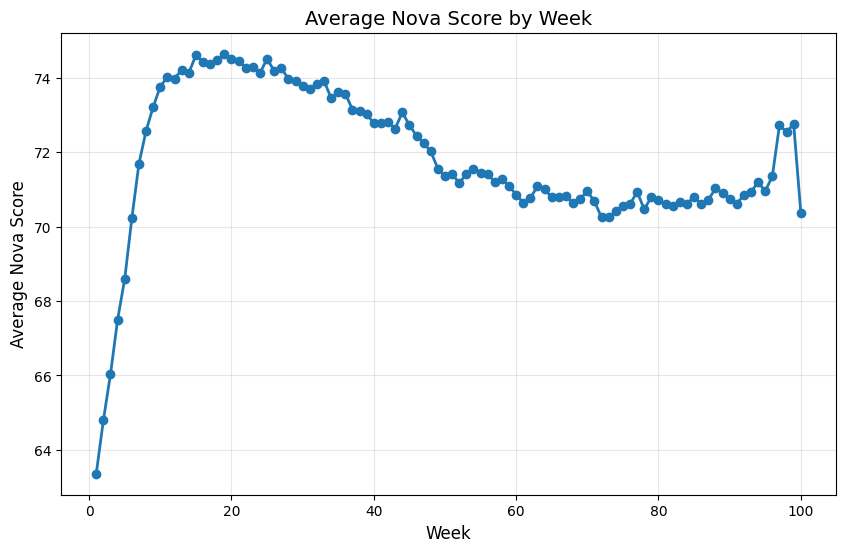

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure 'week' exists in df
avg_by_week = df.groupby("week")["nova_score"].mean()

plt.figure(figsize=(10,6))
plt.plot(avg_by_week.index, avg_by_week.values, marker="o", linewidth=2)
plt.title("Average Nova Score by Week", fontsize=14)
plt.xlabel("Week", fontsize=12)
plt.ylabel("Average Nova Score", fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()


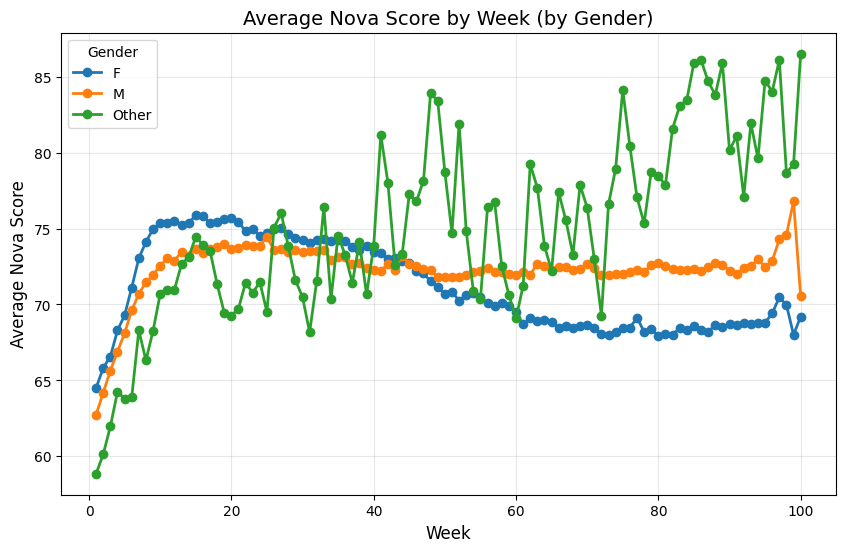

In [ ]:
avg_by_week_gender = df.groupby(["week","gender"])["nova_score"].mean().unstack()

avg_by_week_gender.plot(figsize=(10,6), linewidth=2, marker="o")
plt.title("Average Nova Score by Week (by Gender)", fontsize=14)
plt.xlabel("Week", fontsize=12)
plt.ylabel("Average Nova Score", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(title="Gender")
plt.show()


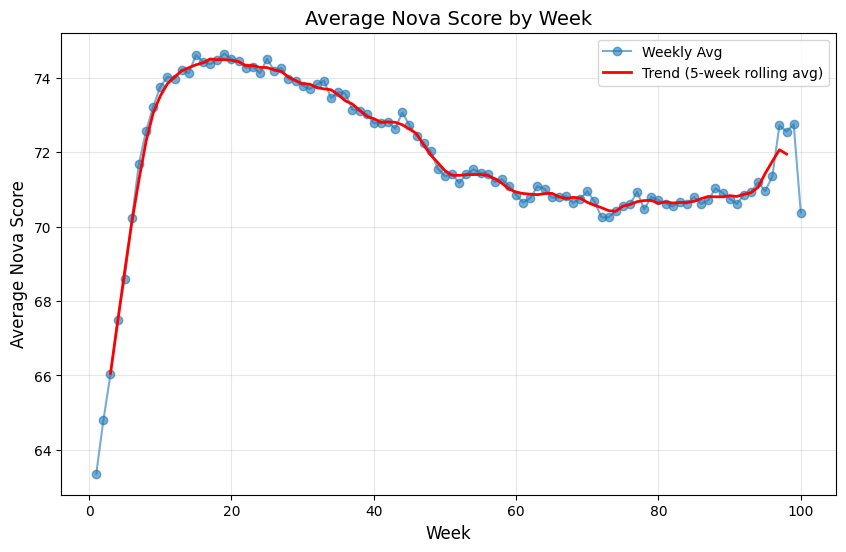

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Average Nova Score by week
avg_by_week = df.groupby("week")["nova_score"].mean()

# Rolling mean for smoothing (window=5 weeks)
rolling_avg = avg_by_week.rolling(window=5, center=True).mean()

plt.figure(figsize=(10,6))
plt.plot(avg_by_week.index, avg_by_week.values, marker="o", linewidth=1.5, alpha=0.6, label="Weekly Avg")
plt.plot(rolling_avg.index, rolling_avg.values, color="red", linewidth=2, label="Trend (5-week rolling avg)")
plt.title("Average Nova Score by Week", fontsize=14)
plt.xlabel("Week", fontsize=12)
plt.ylabel("Average Nova Score", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


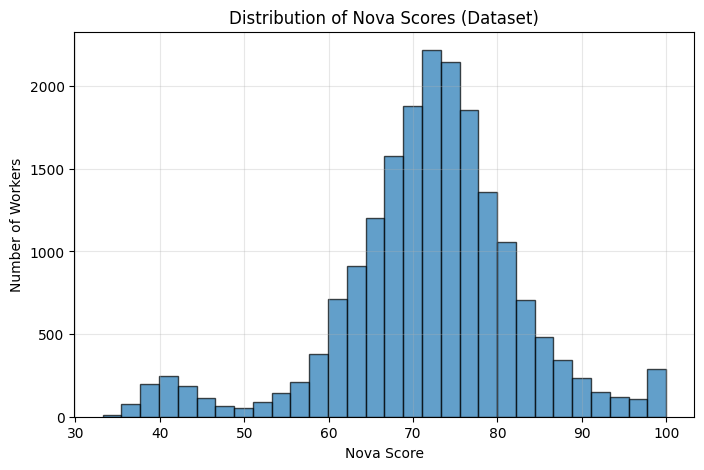

count    19126.000000
mean        71.913852
std         10.838764
min         33.219469
25%         66.910558
50%         72.600207
75%         77.840876
max        100.000000
Name: nova_score, dtype: float64


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("/content/final_nova_dataset.csv")

# Histogram of nova_score
plt.figure(figsize=(8,5))
plt.hist(df["nova_score"], bins=30, edgecolor="black", alpha=0.7)
plt.xlabel("Nova Score")
plt.ylabel("Number of Workers")
plt.title("Distribution of Nova Scores (Dataset)")
plt.grid(True, alpha=0.3)
plt.show()

# Basic stats
print(df["nova_score"].describe())


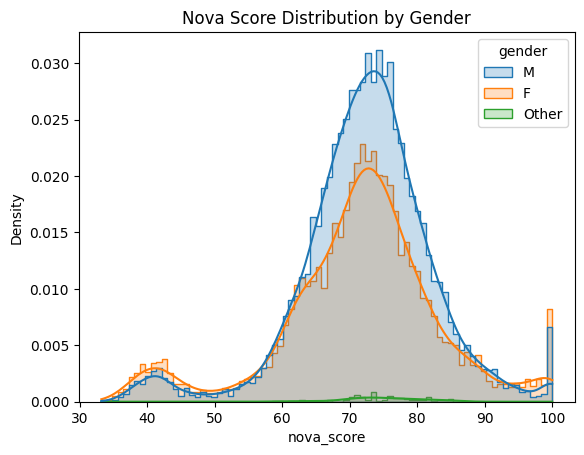

In [ ]:
# Gender distributions
sns.histplot(data=df, x="nova_score", hue="gender", kde=True, element="step", stat="density")
plt.title("Nova Score Distribution by Gender")
plt.show()


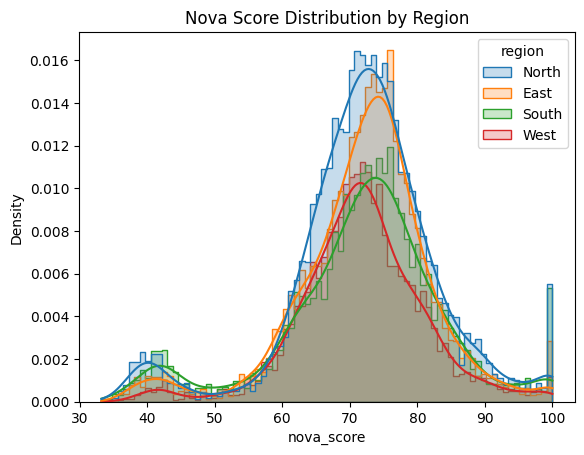

In [ ]:
# Gender distributions
sns.histplot(data=df, x="nova_score", hue="region", kde=True, element="step", stat="density")
plt.title("Nova Score Distribution by Region")
plt.show()


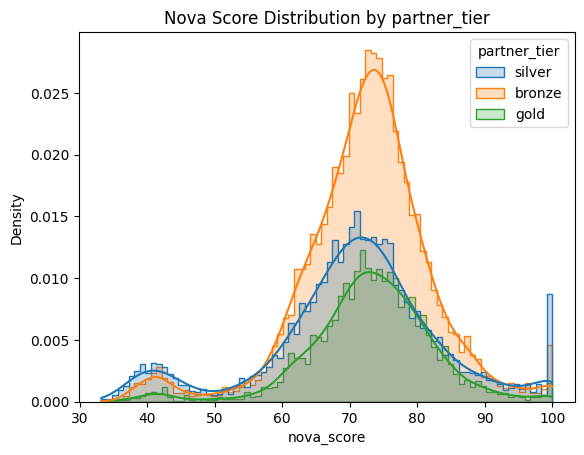

In [ ]:
# Gender distributions
sns.histplot(data=df, x="nova_score", hue="partner_tier", kde=True, element="step", stat="density")
plt.title("Nova Score Distribution by partner_tier")
plt.show()


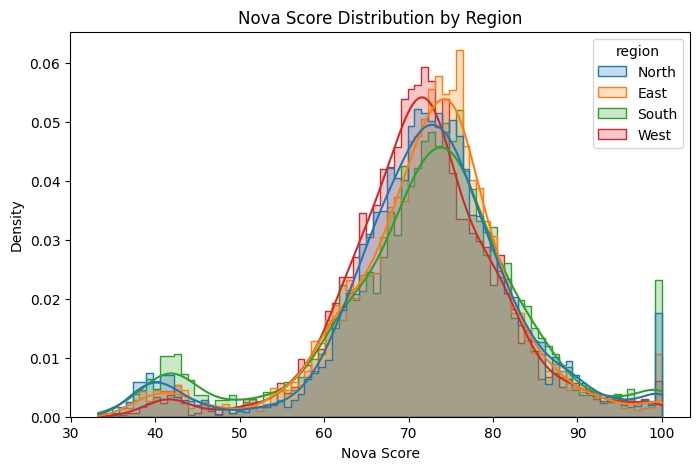

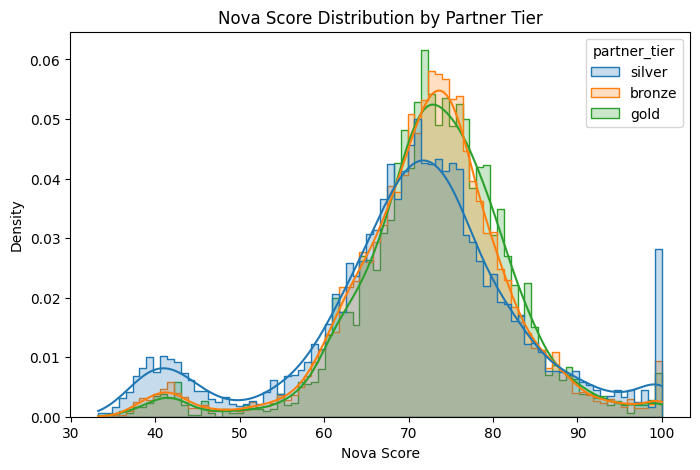

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Distribution of Nova Scores by region
plt.figure(figsize=(8,5))
sns.histplot(data=df, x="nova_score", hue="region", kde=True, element="step", stat="density", common_norm=False)
plt.title("Nova Score Distribution by Region")
plt.xlabel("Nova Score")
plt.ylabel("Density")
plt.show()

# Distribution of Nova Scores by partner_tier
plt.figure(figsize=(8,5))
sns.histplot(data=df, x="nova_score", hue="partner_tier", kde=True, element="step", stat="density", common_norm=False)
plt.title("Nova Score Distribution by Partner Tier")
plt.xlabel("Nova Score")
plt.ylabel("Density")
plt.show()


/tmp/ipython-input-1978320452.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(x="week", y="nova_score", hue="gender", data=df, ci=None)


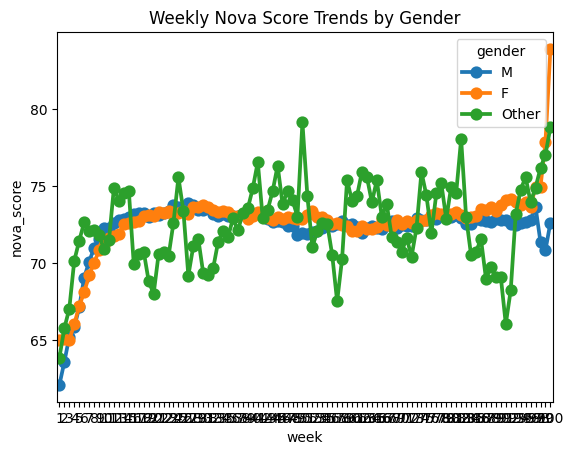

In [ ]:
sns.pointplot(x="week", y="nova_score", hue="gender", data=df, ci=None)
plt.title("Weekly Nova Score Trends by Gender")
plt.show()
